# Desafio

### Modelando o Sistema Bancário em POO com Python 



Atualizar a implementação do sistema bancário para armazenar os dados dos clientes e contas bancárias em objetos.

- Seguir o modelo de classes abaixo.

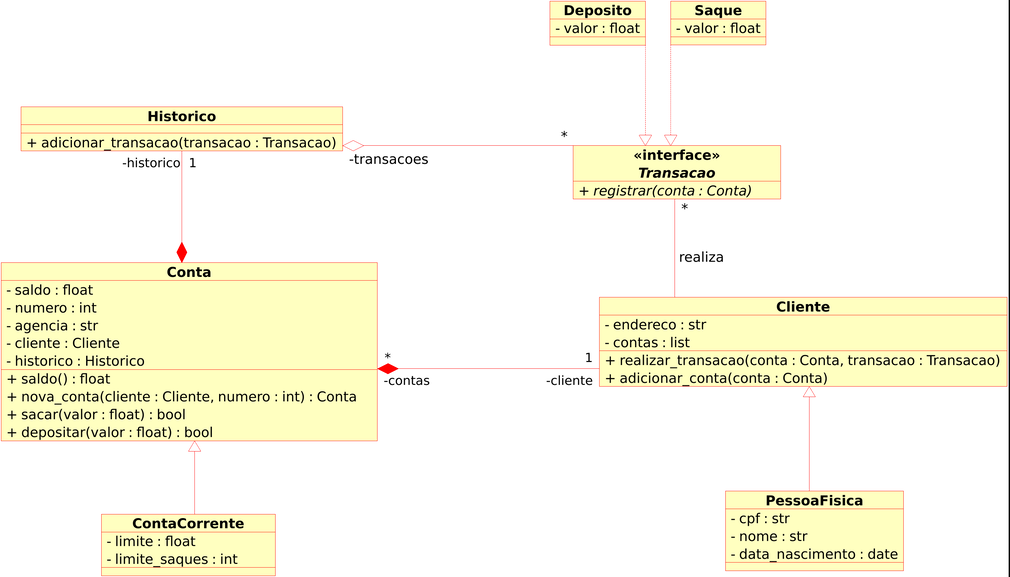

### Classes

In [1]:
import textwrap
from abc import ABC, abstractclassmethod, abstractproperty
from datetime import datetime


class Cliente:
    def __init__(self, endereco):
        self.endereco = endereco
        self.contas = []

    def realizar_transacao(self, conta, transacao):
        transacao.registrar(conta)

    def adicionar_conta(self, conta):
        self.contas.append(conta)


class PessoaFisica(Cliente):
    def __init__(self, nome, data_nascimento, cpf, endereco):
        super().__init__(endereco)
        self.nome = nome
        self.data_nascimento = data_nascimento
        self.cpf = cpf


class Conta:
    def __init__(self, numero, cliente):
        self._saldo = 0
        self._numero = numero
        self._agencia = "0001"
        self._cliente = cliente
        self._historico = Historico()

    @classmethod
    def nova_conta(cls, cliente, numero):
        return cls(numero, cliente)

    @property
    def saldo(self):
        return self._saldo

    @property
    def numero(self):
        return self._numero

    @property
    def agencia(self):
        return self._agencia

    @property
    def cliente(self):
        return self._cliente

    @property
    def historico(self):
        return self._historico

    def sacar(self, valor):
        saldo = self.saldo
        excedeu_saldo = valor > saldo

        if excedeu_saldo:
            print("\n@@@ Operação falhou! Você não tem saldo suficiente. @@@")

        elif valor > 0:
            self._saldo -= valor
            print("\n=== Saque realizado com sucesso! ===")
            return True

        else:
            print("\n@@@ Operação falhou! O valor informado é inválido. @@@")

        return False

    def depositar(self, valor):
        if valor > 0:
            self._saldo += valor
            print("\n=== Depósito realizado com sucesso! ===")
        else:
            print("\n@@@ Operação falhou! O valor informado é inválido. @@@")
            return False

        return True


class ContaCorrente(Conta):
    def __init__(self, numero, cliente, limite=500, limite_saques=3):
        super().__init__(numero, cliente)
        self._limite = limite
        self._limite_saques = limite_saques

    def sacar(self, valor):
        numero_saques = len(
            [transacao for transacao in self.historico.transacoes if transacao["tipo"] == Saque.__name__]
        )

        excedeu_limite = valor > self._limite
        excedeu_saques = numero_saques >= self._limite_saques

        if excedeu_limite:
            print("\n@@@ Operação falhou! O valor do saque excede o limite. @@@")

        elif excedeu_saques:
            print("\n@@@ Operação falhou! Número máximo de saques excedido. @@@")

        else:
            return super().sacar(valor)

        return False

    def __str__(self):
        return f"""\
            Agência:\t{self.agencia}
            C/C:\t\t{self.numero}
            Titular:\t{self.cliente.nome}
        """


class Historico:
    def __init__(self):
        self._transacoes = []

    @property
    def transacoes(self):
        return self._transacoes

    def adicionar_transacao(self, transacao):
        self._transacoes.append(
            {
                "tipo": transacao.__class__.__name__,
                "valor": transacao.valor,
                "data": datetime.now().strftime("%d-%m-%Y %H:%M:%S"),
            }
        )


class Transacao(ABC):
    @property
    @abstractproperty
    def valor(self):
        pass

    @abstractclassmethod
    def registrar(self, conta):
        pass


class Saque(Transacao):
    def __init__(self, valor):
        self._valor = valor

    @property
    def valor(self):
        return self._valor

    def registrar(self, conta):
        sucesso_transacao = conta.sacar(self.valor)

        if sucesso_transacao:
            conta.historico.adicionar_transacao(self)


class Deposito(Transacao):
    def __init__(self, valor):
        self._valor = valor

    @property
    def valor(self):
        return self._valor

    def registrar(self, conta):
        sucesso_transacao = conta.depositar(self.valor)

        if sucesso_transacao:
            conta.historico.adicionar_transacao(self)

### Programa

In [2]:
def menu():
    menu = """\n
    ================ MENU ================
    [d]\tDepositar
    [s]\tSacar
    [e]\tExtrato
    [nc]\tNova conta
    [lc]\tListar contas
    [nu]\tNovo usuário
    [q]\tSair
    => """
    return input(textwrap.dedent(menu))


def filtrar_cliente(cpf, clientes):
    clientes_filtrados = [cliente for cliente in clientes if cliente.cpf == cpf]
    return clientes_filtrados[0] if clientes_filtrados else None


def recuperar_conta_cliente(cliente):
    if not cliente.contas:
        print("\n@@@ Cliente não possui conta! @@@")
        return

    # FIXME: não permite cliente escolher a conta
    return cliente.contas[0]


def depositar(clientes):
    cpf = input("Informe o CPF do cliente: ")
    cliente = filtrar_cliente(cpf, clientes)

    if not cliente:
        print("\n@@@ Cliente não encontrado! @@@")
        return

    valor = float(input("Informe o valor do depósito: "))
    transacao = Deposito(valor)

    conta = recuperar_conta_cliente(cliente)
    if not conta:
        return

    cliente.realizar_transacao(conta, transacao)


def sacar(clientes):
    cpf = input("Informe o CPF do cliente: ")
    cliente = filtrar_cliente(cpf, clientes)

    if not cliente:
        print("\n@@@ Cliente não encontrado! @@@")
        return

    valor = float(input("Informe o valor do saque: "))
    transacao = Saque(valor)

    conta = recuperar_conta_cliente(cliente)
    if not conta:
        return

    cliente.realizar_transacao(conta, transacao)


def exibir_extrato(clientes):
    cpf = input("Informe o CPF do cliente: ")
    cliente = filtrar_cliente(cpf, clientes)

    if not cliente:
        print("\n@@@ Cliente não encontrado! @@@")
        return

    conta = recuperar_conta_cliente(cliente)
    if not conta:
        return

    print("\n================ EXTRATO ================")
    transacoes = conta.historico.transacoes

    extrato = ""
    if not transacoes:
        extrato = "Não foram realizadas movimentações."
    else:
        for transacao in transacoes:
            extrato += f"\n{transacao['tipo']}:\n\tR$ {transacao['valor']:.2f}"

    print(extrato)
    print(f"\nSaldo:\n\tR$ {conta.saldo:.2f}")
    print("==========================================")


def criar_cliente(clientes):
    cpf = input("Informe o CPF (somente número): ")
    cliente = filtrar_cliente(cpf, clientes)

    if cliente:
        print("\n@@@ Já existe cliente com esse CPF! @@@")
        return

    nome = input("Informe o nome completo: ")
    data_nascimento = input("Informe a data de nascimento (dd-mm-aaaa): ")
    endereco = input("Informe o endereço (logradouro, nro - bairro - cidade/sigla estado): ")

    cliente = PessoaFisica(nome=nome, data_nascimento=data_nascimento, cpf=cpf, endereco=endereco)

    clientes.append(cliente)

    print("\n=== Cliente criado com sucesso! ===")


def criar_conta(numero_conta, clientes, contas):
    cpf = input("Informe o CPF do cliente: ")
    cliente = filtrar_cliente(cpf, clientes)

    if not cliente:
        print("\n@@@ Cliente não encontrado, fluxo de criação de conta encerrado! @@@")
        return

    conta = ContaCorrente.nova_conta(cliente=cliente, numero=numero_conta)
    contas.append(conta)
    cliente.contas.append(conta)

    print("\n=== Conta criada com sucesso! ===")


def listar_contas(contas):
    for conta in contas:
        print("=" * 100)
        print(textwrap.dedent(str(conta)))

In [3]:
def main():
    clientes = []
    contas = []

    while True:
        opcao = menu()

        if opcao == "d":
            depositar(clientes)

        elif opcao == "s":
            sacar(clientes)

        elif opcao == "e":
            exibir_extrato(clientes)

        elif opcao == "nu":
            criar_cliente(clientes)

        elif opcao == "nc":
            numero_conta = len(contas) + 1
            criar_conta(numero_conta, clientes, contas)

        elif opcao == "lc":
            listar_contas(contas)

        elif opcao == "q":
            break

        else:
            print("\n@@@ Operação inválida, por favor selecione novamente a operação desejada. @@@")


In [4]:
main()